### 📦 1. ColPali 및 의존 라이브러리 설치
ColPali는 Vision-Language 기반의 임베딩 모델입니다. 이 노트북에서는 이를 활용해 문서를 벡터화하고, Qdrant 벡터 DB에 저장하는 실습을 진행합니다.

먼저 ColPali 관련 라이브러리를 설치합니다.

![alt text](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

In [ ]:
%pip install colpali_engine

### 🚀 2. 주요 라이브러리 임포트
벡터 연산, 저장소 관리, 모델 추론 등을 위해 필요한 패키지를 불러옵니다.

In [1]:
import os
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm

### 🧠 3. ColPali 모델 및 프로세서 로드
사전학습된 ColPali 모델과 전처리 프로세서를 불러옵니다. GPU가 있다면 `cuda:0`을 사용해 추론 속도를 높일 수 있습니다.

In [2]:
from colpali_engine.models import ColPali, ColPaliProcessor

# ColPali 모델 및 프로세서 초기화
model_name = (
    "vidore/colpali-v1.3"  # 사용 가능한 최신 버전 사용
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # GPU는 "cuda:0", CPU는 "cpu", Apple Silicon은 "mps" 사용
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma2-3b-pt-448-base"
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### 🏗️ 4. Qdrant 컬렉션 생성
Qdrant는 유사도 검색을 위한 벡터 데이터베이스입니다. 여기서는 ColPali 벡터 크기에 맞는 임시(in-memory) 컬렉션을 생성합니다.

| 항목                     | 의미                     |
| ---------------------- | ---------------------------- |
| `size=128`             | ColPali가 만든 벡터는 숫자 128개로 구성됨 |
| `distance=COSINE`      | 비슷한 방향 = 비슷한 의미로 판단          |
| `on_disk=True`         | 벡터를 디스크에 저장 (RAM 절약)         |
| `MAX_SIM`              | 여러 벡터 중 가장 유사한 것만 비교         |
| `quantization`         | 벡터 압축 저장 (RAM/디스크 최적화)       |
| `always_ram=True`      | 검색 빠르게 하려고 압축된 것만 메모리에 유지    |
| `on_disk_payload=True` | 설명 정보는 디스크에 저장 (속도·용량 분리)    |

In [3]:
from qdrant_client import QdrantClient
from qdrant_client.http import models

# Qdrant 클라이언트 생성 (메모리 기반)
qdrant_client = QdrantClient(":memory:")
collection_name = "colpali-test"

# Qdrant 컬렉션 생성
qdrant_client.create_collection(
    collection_name=collection_name,
    on_disk_payload=True,  # 페이로드를 디스크에 저장
    vectors_config=models.VectorParams(
        size=128,  # 벡터 차원 수 (128차원)
        distance=models.Distance.COSINE,  # 코사인 유사도 측정 방식 사용
        on_disk=True,  # 원본 벡터를 디스크로 이동하여 메모리 사용량 감소
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM  # 다중 벡터 중 최대 유사도 사용
        ),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True  # 양자화된 벡터만 RAM에 유지하여 검색 속도 향상
            ),
        ),
    ),
)

True

### 🛠️ 5. 추가 유틸 설치
stamina: 실패한 작업을 자동으로 재시도하는 데코레이터 제공
rich: 출력 가독성을 높이는 콘솔 라이브러리

In [ ]:
%pip install stamina rich

### 🔁 6. Qdrant 업서트 함수 정의
임베딩 데이터를 Qdrant에 저장하는 함수입니다. 실패 시 최대 3회까지 재시도합니다.

In [4]:
import stamina

@stamina.retry(on=Exception, attempts=3)  # 작업 중 예외 발생 시 재시도하는 메커니즘
def upsert_to_qdrant(batch):
    """
    Qdrant 벡터 데이터베이스에 데이터를 업서트(삽입 또는 업데이트)하는 함수
    
    Args:
        batch: 업서트할 데이터 배치
        
    Returns:
        bool: 업서트 성공 여부
    """
    try:
        qdrant_client.upsert(
            collection_name=collection_name,  # 데이터를 저장할 컬렉션 이름
            points=points,                    # 업서트할 데이터 포인트
            wait=False,                       # 비동기 처리를 위해 응답 대기하지 않음
        )
    except Exception as e:
        print(f"Error during upsert: {e}")    # 오류 발생 시 출력
        return False                          # 실패 시 False 반환
    return True                               # 성공 시 True 반환

### 📄 7. PDF 파일을 이미지로 변환
PyMuPDF를 이용해 각 페이지를 이미지로 저장합니다. 이후 이미지 임베딩을 위한 전처리 단계입니다.

In [5]:
import os
import fitz  # PyMuPDF 라이브러리

# PDF 파일 열기
doc = fitz.open("./data/국가별 공공부문 AI 도입 및 활용 전략.pdf")

# 이미지를 저장할 디렉토리 생성 (존재하지 않을 경우)
output_dir = "./data/pdf_image"
os.makedirs(output_dir, exist_ok=True)

# PDF의 각 페이지를 이미지로 변환하여 저장
for i, page in enumerate(doc):
    # 페이지를 이미지로 변환 후 PNG 형식으로 저장
    page.get_pixmap().save(f"{output_dir}/{i}.png")

# 작업 완료 후 PDF 문서 닫기
doc.close()

### 🖼️ 8. 이미지 인덱싱 (이미지를 ColPali로 임베딩하여 Qdrant에 저장)

In [6]:
import torch

torch.cuda.empty_cache()       # 할당된 캐시 메모리 해제 (OS에는 반환 안됨)
torch.cuda.ipc_collect()       # 다른 프로세스와 공유된 메모리도 수거

In [7]:
import os
from tqdm import tqdm
import torch
from PIL import Image

os.makedirs("./data/pdf_image", exist_ok=True)
image_files = [f"./data/pdf_image/{i}.png" for i in range(len(os.listdir("./data/pdf_image")))]
batch_size = 4

with tqdm(total=len(image_files), desc="Indexing Progress") as pbar:
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i : i + batch_size]
        images = [Image.open(img_path) for img_path in batch_files]

        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)

        points = []
        for j, embedding in enumerate(image_embeddings):
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(models.PointStruct(
                id=i + j,
                vector=multivector,
                payload={"source": "pdf_image", "file_path": batch_files[j]},
            ))

        try:
            upsert_to_qdrant(points)
        except Exception as e:
            print(f"업로드 중 오류 발생: {e}")
            continue

        pbar.update(len(batch_files))

print("인덱싱 완료!")

Indexing Progress: 100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

인덱싱 완료!


### 🔍 9. 질의 텍스트를 ColPali로 임베딩

In [8]:
# 질의 텍스트 설정
query_text = "스마트폰을 들고 있는 그림"

# 모델 추론 시 그래디언트 계산 비활성화
with torch.no_grad():
    # 질의 텍스트를 모델이 처리할 수 있는 형태로 변환하고 적절한 장치로 이동
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    # 변환된 질의를 모델에 입력하여 임베딩 생성
    query_embedding = colpali_model(**batch_query)

# 생성된 질의 임베딩 출력
query_embedding

tensor([[[-0.0047,  0.1465,  0.1602,  ..., -0.0287, -0.2129, -0.1235],
         [-0.0439,  0.0254,  0.0898,  ..., -0.0046, -0.1807,  0.0535],
         [-0.1250,  0.0342,  0.1318,  ...,  0.0317, -0.0184,  0.0229],
         ...,
         [-0.0674,  0.0222,  0.0272,  ...,  0.0275,  0.1235, -0.0640],
         [-0.0603,  0.0030, -0.0089,  ...,  0.0076,  0.1660, -0.0228],
         [-0.0967,  0.0220,  0.0674,  ..., -0.0187,  0.2178, -0.0045]]],
       device='cuda:0', dtype=torch.bfloat16)

### 📐 10. 질의 벡터 변환 (멀티벡터 쿼리용 리스트)

In [9]:
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

### 🚀 11. Qdrant에서 벡터 검색 실행

In [10]:
start_time = time.time()
# Qdrant 벡터 DB에서 멀티벡터 쿼리 실행
search_result = qdrant_client.query_points(
    collection_name=collection_name,  # 검색할 컬렉션 이름
    query=multivector_query,          # 멀티벡터 쿼리 (여러 필드에 대한 벡터 쿼리)
    limit=10,                         # 최대 10개 결과 반환
    timeout=100,                      # 쿼리 타임아웃 (100ms)
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,               # 양자화 무시하지 않음
            rescore=True,               # 검색 후 원본 벡터로 재점수 계산
            oversampling=2.0,           # 양자화 검색 시 2배 더 많은 후보 검색 (정확도 향상)
        )
    )
)
end_time = time.time()
# 검색 결과 포인트(문서) 확인
search_result.points

# 검색 소요 시간 계산 및 출력
elapsed_time = end_time - start_time
print(f"Search completed in {elapsed_time:.4f} seconds")

Search completed in 0.0498 seconds


### 🖼️ 12. 검색된 이미지 경로 확인 및 시각화

이미지 경로: ./data/pdf_image/20.png


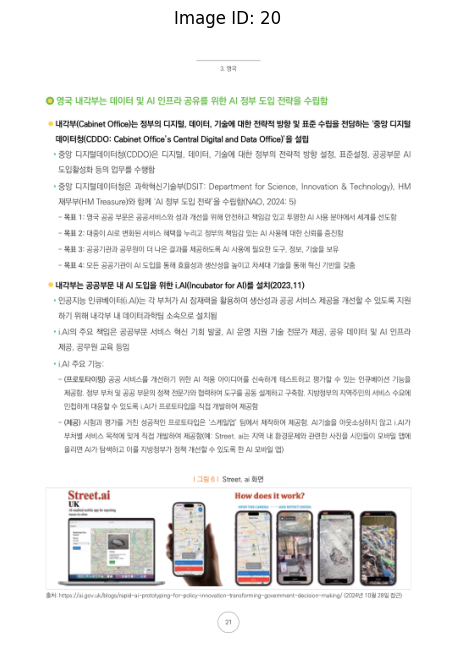

In [11]:
idx = search_result.points[0].id
image_path = image_files[idx]
print(f"이미지 경로: {image_path}")

# 이미지 시각화
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 불러오기 및 표시
img = Image.open(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image ID: {idx}")
plt.show()